In [1]:
%matplotlib inline

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt
from scipy.stats import uniform, randint

In [3]:
# path to project directory
path = Path('./')

In [4]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [5]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,1617,NaN
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,1617,NaN
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,1617,NaN
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,1617,NaN
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,1617,NaN


In [6]:
def gen_lag_features(df, features, lags):
    for feature in features:
        for lag in lags:
            feature_name = str(feature) + '_last_' + str(lag)
            
            if lag == 'all':
                df[feature_name] = df.groupby(['player'])[feature].apply(lambda x: x.cumsum() - x)
            else: 
                df[feature_name] =df.groupby(['player'])[feature].apply(lambda x: x.rolling(min_periods=1, 
                                                                                            window=lag+1).sum() - x)   

In [7]:
gen_lag_features(train_df, ['minutes', 'total_points'], ['all', 1, 2, 3, 4, 5, 10, 20])

In [117]:
train_df['ppg_all'] = 90 * train_df['total_points_last_all']/train_df['minutes_last_all']
train_df['ppg_last_1'] = 90 * train_df['total_points_last_1']/train_df['minutes_last_1']
train_df['ppg_last_2'] = 90 * train_df['total_points_last_2']/train_df['minutes_last_2']
train_df['ppg_last_3'] = 90 * train_df['total_points_last_3']/train_df['minutes_last_3']
train_df['ppg_last_4'] = 90 * train_df['total_points_last_4']/train_df['minutes_last_4']
train_df['ppg_last_5'] = 90 * train_df['total_points_last_5']/train_df['minutes_last_5']
train_df['ppg_last_10'] = 90 * train_df['total_points_last_10']/train_df['minutes_last_10']

In [118]:
train_df['ppg_all'] = train_df['ppg_all'].fillna(0)
train_df['ppg_last_1'] = train_df['ppg_last_1'].fillna(0)
train_df['ppg_last_2'] = train_df['ppg_last_2'].fillna(0)
train_df['ppg_last_3'] = train_df['ppg_last_3'].fillna(0)
train_df['ppg_last_4'] = train_df['ppg_last_4'].fillna(0)
train_df['ppg_last_5'] = train_df['ppg_last_5'].fillna(0)
train_df['ppg_last_10'] = train_df['ppg_last_10'].fillna(0)

In [119]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,total_points_last_5,total_points_last_10,total_points_last_20,ppg_all,ppg_last_5,ppg_last_1,ppg_last_2,ppg_last_3,ppg_last_4,ppg_last_10
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
#train_df['ppm_total'] = train_df['points_cumulative']/train_df['mins_cumulative']
#train_df

In [121]:
#train_df['ppm_last_5'] = train_df['points_last_5']/train_df['mins_last_5']
#train_df

In [122]:
train_df[train_df['player'] == 'Mohamed_Salah'].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,total_points_last_5,total_points_last_10,total_points_last_20,ppg_all,ppg_last_5,ppg_last_1,ppg_last_2,ppg_last_3,ppg_last_4,ppg_last_10
24036,Mohamed_Salah,1,3,85,Liverpool,Watford,1.619155,0.547242,False,11,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24551,Mohamed_Salah,2,3,29,Liverpool,Crystal Palace,1.619155,0.635984,True,1,...,11.0,11.0,11.0,11.647059,11.647059,11.647059,11.647059,11.647059,11.647059,11.647059
25076,Mohamed_Salah,3,3,90,Liverpool,Arsenal,1.619155,2.073500,True,11,...,12.0,12.0,12.0,9.473684,9.473684,3.103448,9.473684,9.473684,9.473684,9.473684
25614,Mohamed_Salah,4,3,45,Liverpool,Manchester City,1.619155,2.016093,False,1,...,23.0,23.0,23.0,10.147059,10.147059,11.000000,9.075630,10.147059,10.147059,10.147059
26160,Mohamed_Salah,5,3,90,Liverpool,Burnley,1.619155,0.316798,True,10,...,24.0,24.0,24.0,8.674699,8.674699,2.000000,8.000000,7.134146,8.674699,8.674699
26708,Mohamed_Salah,6,3,90,Liverpool,Leicester City,1.619155,0.824624,False,7,...,34.0,34.0,34.0,9.026549,9.026549,10.000000,7.333333,8.800000,8.149606,9.026549
27261,Mohamed_Salah,7,3,83,Liverpool,Newcastle United,1.619155,0.547176,False,2,...,30.0,41.0,41.0,8.601399,7.848837,7.000000,8.500000,7.200000,8.285714,8.601399
27817,Mohamed_Salah,8,3,77,Liverpool,Manchester United,1.619155,2.110135,True,3,...,31.0,43.0,43.0,7.558594,7.010050,2.168675,4.682081,6.501901,5.844156,7.558594
28376,Mohamed_Salah,9,3,90,Liverpool,Tottenham Hotspur,1.619155,1.751141,False,7,...,23.0,46.0,46.0,7.028862,5.376623,3.506494,2.812500,4.320000,5.823529,7.028862
28939,Mohamed_Salah,10,3,80,Liverpool,Huddersfield Town,1.619155,0.210654,True,4,...,29.0,53.0,53.0,7.025037,6.069767,7.000000,5.389222,4.320000,5.029412,7.025037


In [123]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78390 entries, 0 to 78389
Data columns (total 35 columns):
player                                 78390 non-null object
gw                                     78390 non-null int64
position                               78390 non-null int64
minutes                                78390 non-null int64
team                                   78390 non-null object
opponent_team                          78390 non-null object
relative_market_value_team             78390 non-null float64
relative_market_value_opponent_team    78390 non-null float64
was_home                               78390 non-null bool
total_points                           78390 non-null int64
season                                 78390 non-null object
play_proba                             10385 non-null float64
minutes_last_all                       78390 non-null int64
minutes_last_1                         78390 non-null float64
minutes_last_2                         7

In [124]:
# set categorical, continuous variables
# and dependent variable
cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['gw', 'minutes', 'relative_market_value_team', 
             'relative_market_value_opponent_team', 
#              'minutes_last_all', 
#              'minutes_last_1', 
#              'minutes_last_2',
#              'minutes_last_3',
#              'minutes_last_4',
#              'minutes_last_5',
#              'minutes_last_10',
#              'minutes_last_20',
#              'total_points_last_all',
#              'total_points_last_1',
#              'total_points_last_2',
#              'total_points_last_3',
#              'total_points_last_4',
#              'total_points_last_5',
#              'total_points_last_10',
#              'total_points_last_20',
             'ppg_all',
             'ppg_last_1',
             'ppg_last_2',
             'ppg_last_3',
             'ppg_last_4',
             'ppg_last_5',
             'ppg_last_10']
dep_var = 'total_points'

In [125]:
X, y = train_df[cat_vars + cont_vars].copy(), train_df[dep_var].copy()

In [126]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 20)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()

In [127]:
X['position'] = X['position'].apply(str)

In [128]:
#X['season'] = X['season'].replace({'1617':1, '1718':2, '1819':3, '1920':4})
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])

In [129]:
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

In [130]:
X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
X_df.head()

,gw,minutes,opponent_team_Arsenal,opponent_team_Aston Villa,opponent_team_Bournemouth,opponent_team_Brighton and Hove Albion,opponent_team_Burnley,opponent_team_Cardiff City,opponent_team_Chelsea,opponent_team_Crystal Palace,...,team_Southampton,team_Stoke City,team_Sunderland,team_Swansea City,team_Tottenham Hotspur,team_Watford,team_West Bromwich Albion,team_West Ham United,team_Wolverhampton Wanderers,was_home
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [131]:
X_df.columns

Index(['gw', 'minutes', 'opponent_team_Arsenal', 'opponent_team_Aston Villa',
       'opponent_team_Bournemouth', 'opponent_team_Brighton and Hove Albion',
       'opponent_team_Burnley', 'opponent_team_Cardiff City',
       'opponent_team_Chelsea', 'opponent_team_Crystal Palace',
       'opponent_team_Everton', 'opponent_team_Fulham',
       'opponent_team_Huddersfield Town', 'opponent_team_Hull City',
       'opponent_team_Leicester City', 'opponent_team_Liverpool',
       'opponent_team_Manchester City', 'opponent_team_Manchester United',
       'opponent_team_Middlesbrough', 'opponent_team_Newcastle United',
       'opponent_team_Norwich', 'opponent_team_Sheffield United',
       'opponent_team_Southampton', 'opponent_team_Stoke City',
       'opponent_team_Sunderland', 'opponent_team_Swansea City',
       'opponent_team_Tottenham Hotspur', 'opponent_team_Watford',
       'opponent_team_West Bromwich Albion', 'opponent_team_West Ham United',
       'opponent_team_Wolverhampton Wand

In [148]:
X_train = X_df[0:valid_end]
y_train = y[0:valid_end]

In [149]:
test_fold = np.repeat([-1, 0], [valid_start, valid_end - valid_start])

In [150]:
len(test_fold)

67936

In [151]:
ps = PredefinedSplit(test_fold)

In [152]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    #'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'learning_rate': [0.1]
}

In [153]:
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

In [154]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

In [155]:
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=25, 
                                    cv=ps, 
                                    verbose=1)

In [156]:
xgb.__version__

'0.90'

In [157]:
# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
          error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6acd68>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6ac8d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6bc5c0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_fr

In [158]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'gamma': 0.35230664269238343, 'learning_rate': 0.03214867523376804, 'max_depth': 5, 'n_estimators': 197, 'subsample': 0.7554749548877047}
Lowest RMSE found:  1.8450282939546638


In [143]:
# training and validation sets
X_train = X_df[0:valid_start]
y_train = y[0:valid_start]
X_test = X_df[valid_start:valid_end]
y_test = y[valid_start:valid_end]

In [146]:
#xg_reg = xgb.XGBRegressor(n_estimators=75, max_depth=5, learning_rate=0.1)

xg_reg = xgb.XGBRegressor(gamma=0.047479, learning_rate=0.0828905304021426, max_depth=5, n_estimators=75, subsample=0.6862963240045978)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(preds, y_test))
print("RMSE: %f" % (rmse))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.845770


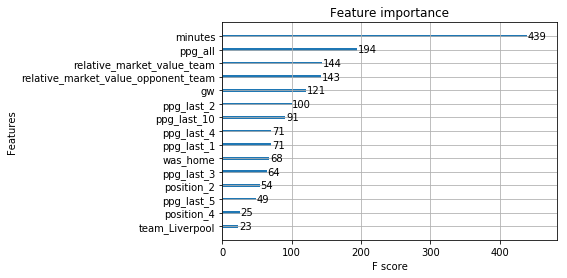

In [147]:
#plt.style.use('ggplot')
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

In [59]:
max(preds)

8.015433

In [22]:
results = X_test.merge(y_test.to_frame(), left_index=True, right_index=True)
results['preds'] = preds
results

,gw,minutes,opponent_team_Arsenal,opponent_team_Aston Villa,opponent_team_Bournemouth,opponent_team_Brighton and Hove Albion,opponent_team_Burnley,opponent_team_Cardiff City,opponent_team_Chelsea,opponent_team_Crystal Palace,...,team_Sunderland,team_Swansea City,team_Tottenham Hotspur,team_Watford,team_West Bromwich Albion,team_West Ham United,team_Wolverhampton Wanderers,was_home,total_points,preds
56539,20.0,90.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3.174152
56540,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.029738
56541,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.027991
56542,20.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.892542
56543,20.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2.021116
56544,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.018358
56545,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.027991
56546,20.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7,1.363438
56547,20.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,1.608021
56548,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.005136
